In [6]:
import os
import re
import numpy as np
import pandas as pd
from scipy import stats

def clean_and_convert_to_csv(file_path, output_csv_path):
    """
    Clean a text file by removing rows that don't match the required pattern,
    convert to CSV, and calculate column averages after removing outliers.
    
    Args:
        file_path (str): Path to the input text file
        output_csv_path (str): Path to save the cleaned CSV file
    
    Returns:
        tuple: (total_rows, valid_rows, column_averages, outliers_removed) statistics
    """
    # Pattern for six numbers separated by spaces
    pattern = r'^\s*(\d+(?:\.\d+)?)\s+(\d+(?:\.\d+)?)\s+(\d+(?:\.\d+)?)\s+(\d+(?:\.\d+)?)\s+(\d+(?:\.\d+)?)\s+(\d+(?:\.\d+)?)\s*$'
    
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        total_rows = len(lines)
        valid_data = []
        
        # Validate rows and extract numeric data
        for line in lines:
            match = re.match(pattern, line.strip())
            if match:
                # Extract the numeric values from the match groups
                numeric_values = [float(match.group(i)) for i in range(1, 7)]
                valid_data.append(numeric_values)
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
        
        # Convert to DataFrame for easier handling and CSV conversion
        if valid_data:
            # Create DataFrame with appropriate column names
            df = pd.DataFrame(valid_data, columns=['Value1', 'Value2', 'Value3', 'Value4', 'Value5', 'Value6'])
            original_row_count = len(df)

            # Create a copy of the original data for the output file
            original_df = df.copy()
            
            # Track outliers removed for each column
            outliers_removed = {}
            outlier_rows = set()  # Track rows that have outliers in any column
            
            # Detect and remove outliers column-wise using z-score method
            for column in df.columns:
                # Calculate z-scores for the column
                z_scores = np.abs(stats.zscore(df[column]))
                
                # Identify outliers (z-score > 3)
                column_outliers = np.where(z_scores > 3)[0]
                
                if len(column_outliers) > 0:
                    # Add to the set of outlier rows
                    outlier_rows.update(column_outliers)
                    outliers_removed[column] = len(column_outliers)
            
            # Remove outlier rows from the dataframe
            if outlier_rows:
                df = df.drop(index=list(outlier_rows))
            
            # Calculate column averages after outlier removal
            column_averages = df.mean().to_dict()
            
            # Add a row with averages at the bottom of the original DataFrame
            original_df.loc['Average'] = df.mean()  # Using averages after outlier removal
            
            # Add a row with information about outliers
            original_df.loc['Outliers_Removed'] = [outliers_removed.get(col, 0) for col in original_df.columns]
            
            # Save to CSV
            original_df.to_csv(output_csv_path, index=True)
            
            return total_rows, original_row_count, column_averages, len(outlier_rows)
        else:
            # No valid data found
            # Create empty CSV with headers
            pd.DataFrame(columns=['Value1', 'Value2', 'Value3', 'Value4', 'Value5', 'Value6']).to_csv(output_csv_path, index=False)
            
            return total_rows, 0, {}, 0
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return 0, 0, {}, 0

def process_all_folders(base_dir, output_base_dir):
    """
    Process all folders and subfolders containing text files.
    
    Args:
        base_dir (str): Base directory containing all data folders
        output_base_dir (str): Base directory to save cleaned CSV files
    """
    # Statistics
    total_files_processed = 0
    total_rows_processed = 0
    total_valid_rows = 0
    total_outliers_removed = 0
    
    # Dictionary to store average values by folder
    folder_averages = {}
    
    # New data collection for the requested format
    location_density_data = []
    
    # Create a summary report
    summary_report_path = os.path.join(output_base_dir, "summary_report.txt")
    averages_csv_path = os.path.join(output_base_dir, "all_averages.csv")
    main_output_csv_path = os.path.join(output_base_dir, "main_location_density_summary.csv")
    outlier_summary_path = os.path.join(output_base_dir, "outlier_summary.txt")
    os.makedirs(os.path.dirname(summary_report_path), exist_ok=True)
    
    # Process each main folder
    with open(summary_report_path, 'w') as summary_file, open(outlier_summary_path, 'w') as outlier_file:
        summary_file.write("NPK Data Cleaning and Analysis Summary Report\n")
        summary_file.write("=" * 60 + "\n\n")
        
        outlier_file.write("Outlier Detection Summary Report\n")
        outlier_file.write("=" * 60 + "\n\n")
        outlier_file.write("This report shows the number of outliers removed in each file based on z-score > 3 criterion.\n\n")
        
        # Process each main folder
        for main_folder in sorted(os.listdir(base_dir)):
            main_folder_path = os.path.join(base_dir, main_folder)
            
            # Skip if not a directory
            if not os.path.isdir(main_folder_path):
                continue
            
            print(f"Processing main folder: {main_folder}")
            summary_file.write(f"\nFolder: {main_folder}\n")
            summary_file.write("-" * 40 + "\n")
            
            outlier_file.write(f"\nFolder: {main_folder}\n")
            outlier_file.write("-" * 40 + "\n")
            
            folder_files_processed = 0
            main_folder_averages = {}
            folder_outliers_removed = 0
            
            # Look for density folders (d_60, d_80, etc.)
            for density_folder in sorted(os.listdir(main_folder_path)):
                if not density_folder.startswith('d_'):
                    continue
                
                # Extract the density value from the folder name
                density_value = density_folder.split('_')[1] if len(density_folder.split('_')) > 1 else "unknown"
                
                density_folder_path = os.path.join(main_folder_path, density_folder)
                
                # Skip if not a directory
                if not os.path.isdir(density_folder_path):
                    continue
                
                summary_file.write(f"  Density {density_value}:\n")
                outlier_file.write(f"  Density {density_value}:\n")
                
                density_averages = {'Value1': [], 'Value2': [], 'Value3': [], 'Value4': [], 'Value5': [], 'Value6': []}
                density_outliers_removed = 0
                
                # Process text files in the density folder
                for filename in sorted(os.listdir(density_folder_path)):
                    if not filename.endswith('.txt'):
                        continue
                    
                    input_file_path = os.path.join(density_folder_path, filename)
                    
                    # Create corresponding output paths
                    relative_path = os.path.relpath(input_file_path, base_dir)
                    output_csv_path = os.path.join(output_base_dir, os.path.splitext(relative_path)[0] + '.csv')
                    
                    # Process the file
                    total_rows, valid_rows, column_avgs, outliers = clean_and_convert_to_csv(
                        input_file_path, output_csv_path
                    )
                    
                    # Add to density averages if valid data exists
                    if column_avgs:
                        for col, avg in column_avgs.items():
                            density_averages[col].append(avg)
                    
                    print(f"  Processed {input_file_path}: {valid_rows}/{total_rows} valid rows, {outliers} outliers removed")
                    summary_file.write(f"    {filename}: {valid_rows}/{total_rows} valid rows\n")
                    outlier_file.write(f"    {filename}: {outliers} outliers removed\n")
                    
                    if column_avgs:
                        summary_file.write(f"      Averages (after outlier removal): ")
                        for col, avg in column_avgs.items():
                            summary_file.write(f"{col}={avg:.2f} ")
                        summary_file.write("\n")
                    
                    total_files_processed += 1
                    folder_files_processed += 1
                    total_rows_processed += total_rows
                    total_valid_rows += valid_rows
                    total_outliers_removed += outliers
                    density_outliers_removed += outliers
                    folder_outliers_removed += outliers
                
                # Calculate and store density level averages
                density_level_avgs = {}
                for col, values in density_averages.items():
                    if values:
                        density_level_avgs[col] = sum(values) / len(values)
                
                # Add to folder averages
                key = f"{main_folder}/{density_folder}"
                folder_averages[key] = density_level_avgs
                
                # Calculate overall average of all six values for this location and density
                if density_level_avgs:
                    overall_avg = sum(density_level_avgs.values()) / len(density_level_avgs)
                    # Store in the format requested: location, avg of 6 values, density value
                    location_density_data.append({
                        'Location': main_folder,
                        'Density': density_value,
                        'Overall_Average': overall_avg
                    })
                
                # Write density level averages to summary
                if density_level_avgs:
                    summary_file.write(f"    Density {density_value} Averages: ")
                    for col, avg in density_level_avgs.items():
                        summary_file.write(f"{col}={avg:.2f} ")
                        # Accumulate for main folder averages
                        if col not in main_folder_averages:
                            main_folder_averages[col] = []
                        main_folder_averages[col].append(avg)
                    summary_file.write("\n")
                
                outlier_file.write(f"    Total outliers removed for Density {density_value}: {density_outliers_removed}\n")
            
            # Calculate main folder level averages
            main_folder_level_avgs = {}
            for col, values in main_folder_averages.items():
                if values:
                    main_folder_level_avgs[col] = sum(values) / len(values)
            
            # Add to folder averages
            folder_averages[main_folder] = main_folder_level_avgs
            
            # Write main folder summary
            summary_file.write(f"\n  {main_folder} Summary: {folder_files_processed} files processed\n")
            if main_folder_level_avgs:
                summary_file.write(f"  {main_folder} Overall Averages: ")
                for col, avg in main_folder_level_avgs.items():
                    summary_file.write(f"{col}={avg:.2f} ")
                summary_file.write("\n")
            
            outlier_file.write(f"\n  {main_folder} Summary: {folder_outliers_removed} total outliers removed\n")
        
        # Write overall summary
        summary_file.write("\n\nOVERALL SUMMARY\n")
        summary_file.write("=" * 40 + "\n")
        summary_file.write(f"Total files processed: {total_files_processed}\n")
        summary_file.write(f"Total rows processed: {total_rows_processed}\n")
        summary_file.write(f"Total valid rows: {total_valid_rows}\n")
        summary_file.write(f"Total outliers removed: {total_outliers_removed}\n")
        if total_rows_processed > 0:
            summary_file.write(f"Percentage of valid data: {(total_valid_rows/total_rows_processed)*100:.2f}%\n")
        
        outlier_file.write("\n\nOVERALL SUMMARY\n")
        outlier_file.write("=" * 40 + "\n")
        outlier_file.write(f"Total files processed: {total_files_processed}\n")
        outlier_file.write(f"Total outliers removed: {total_outliers_removed}\n")
        if total_valid_rows > 0:
            outlier_file.write(f"Percentage of data identified as outliers: {(total_outliers_removed/total_valid_rows)*100:.2f}%\n")
    
    # Save all averages to CSV
    averages_df = pd.DataFrame.from_dict(folder_averages, orient='index')
    averages_df.index.name = 'Folder'
    averages_df.to_csv(averages_csv_path)
    
    # Save the main location-density summary data - simplified format
    if location_density_data:
        main_output_df = pd.DataFrame(location_density_data)
        main_output_df = main_output_df.sort_values(['Location', 'Density'])
        # Format the column names exactly as requested
        main_output_df.columns = ['Name of the place', 'value of the density', 'averaged value of the six values']
        # Reorder columns to match requested format
        main_output_df = main_output_df[['Name of the place', 'averaged value of the six values', 'value of the density']]
        main_output_df.to_csv(main_output_csv_path, index=False)
    
    # Print overall summary
    print("\nProcessing complete!")
    print(f"Total files processed: {total_files_processed}")
    print(f"Total rows processed: {total_rows_processed}")
    print(f"Total valid rows: {total_valid_rows}")
    print(f"Total outliers removed: {total_outliers_removed}")
    if total_rows_processed > 0:
        print(f"Percentage of valid data: {(total_valid_rows/total_rows_processed)*100:.2f}%")
    print(f"Summary report saved to: {summary_report_path}")
    print(f"Outlier report saved to: {outlier_summary_path}")
    print(f"All folder averages saved to: {averages_csv_path}")
    print(f"Main location-density summary saved to: {main_output_csv_path}")

if __name__ == "__main__":
    # Get input from user
    base_directory = input("Enter the base directory path (e.g., path to 'rawdata' folder): ")
    output_directory = input("Enter the output directory path for cleaned CSV files and reports: ")
    
    # Process all folders
    process_all_folders(base_directory, output_directory)

Enter the base directory path (e.g., path to 'rawdata' folder):  rawdata
Enter the output directory path for cleaned CSV files and reports:  data_without_outliers


Processing main folder: Itala_afterChange
  Processed rawdata\Itala_afterChange\d_100\1.txt: 774/779 valid rows, 6 outliers removed
  Processed rawdata\Itala_afterChange\d_100\2.txt: 698/702 valid rows, 15 outliers removed
  Processed rawdata\Itala_afterChange\d_100\3.txt: 622/625 valid rows, 12 outliers removed
  Processed rawdata\Itala_afterChange\d_100\4.txt: 610/613 valid rows, 2 outliers removed
  Processed rawdata\Itala_afterChange\d_100\5.txt: 635/639 valid rows, 5 outliers removed
  Processed rawdata\Itala_afterChange\d_100\6.txt: 466/469 valid rows, 2 outliers removed
  Processed rawdata\Itala_afterChange\d_120\1.txt: 656/660 valid rows, 4 outliers removed
  Processed rawdata\Itala_afterChange\d_120\2.txt: 669/671 valid rows, 9 outliers removed
  Processed rawdata\Itala_afterChange\d_120\3.txt: 657/660 valid rows, 24 outliers removed
  Processed rawdata\Itala_afterChange\d_120\4.txt: 670/673 valid rows, 9 outliers removed
  Processed rawdata\Itala_afterChange\d_120\5.txt: 664/

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor  # Correct import
from sklearn.decomposition import PCA # Importing PCA
# Load the dataset
data = pd.read_csv('all_averages_without_outliers.csv')

# Define features and target variables
features = ['N_A', 'P_A', 'K_A', 'N_T', 'P_T', 'K_T']
targets = ['N_Quantity', 'P_Quantity', 'K_Quantity']

X = data[features]
y = data[targets]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering: Dimensionality Reduction using PCA
pca = PCA(n_components=4)  # Reduce to 4 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define a function to create the neural network model for hyperparameter tuning
def create_model(learning_rate=0.001, num_neurons=64):
    model = Sequential([
        Dense(num_neurons, activation='relu', input_dim=X_train_pca.shape[1]),
        Dense(num_neurons // 2, activation='relu'),
        Dense(y_train.shape[1])  # Output layer with three neurons (one per target variable)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Wrap the model using KerasRegressor for hyperparameter tuning
model = KerasRegressor(model=create_model, verbose=0) # Correct usage

# Define hyperparameters for Grid Search
param_grid = {
    'model__learning_rate': [0.001, 0.01],  # Corrected naming
    'model__num_neurons': [32, 64], # Corrected naming
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train)

# Print the best parameters and score from Grid Search
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train the final model with optimized hyperparameters
best_model = grid_search.best_estimator_

# Predict values for the test set
predictions = best_model.predict(X_test_pca)

# Calculate the R-squared score for each target variable
r2_scores = {}
for i, target in enumerate(targets):
    r2_scores[target] = r2_score(y_test.iloc[:, i], predictions[:, i])

print("R-Squared Scores:")
print(r2_scores)

# Evaluate the model on the test set
loss, mae = best_model.model_.evaluate(X_test_pca, y_test, verbose=0) # Corrected evaluation
print(f"Test Loss: {loss}, Test MAE: {mae}")


C:\Users\ganes\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ganes\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ganes\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs

Best Hyperparameters: {'batch_size': 16, 'epochs': 100, 'model__learning_rate': 0.01, 'model__num_neurons': 64}
Best Score: -1.2857712770707994
R-Squared Scores:
{'N_Quantity': 0.5704383126399316, 'P_Quantity': -3.2406117709827784, 'K_Quantity': 0.3390682287236332}
Test Loss: 5.487241744995117, Test MAE: 1.2549902200698853


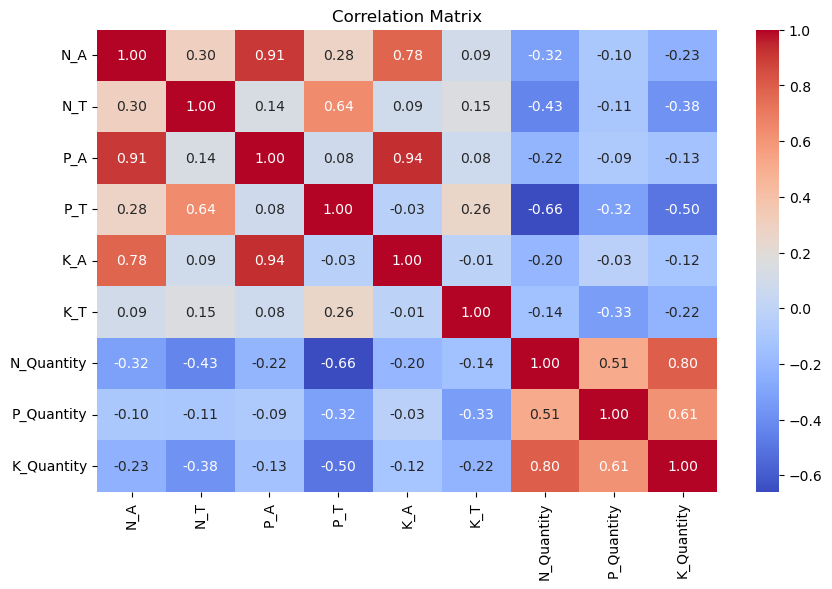

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import itertools

# Load data
df = pd.read_csv("all_averages_without_outliers.csv")

# Drop the first column
df = df.iloc[:, 1:]

# Correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()




In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import itertools

# Load data
df = pd.read_csv("all_averages_without_outliers.csv")

# Extract locations and densities
df['Location'] = df.iloc[:, 0].apply(lambda x: x.split('/')[0])
df['Density'] = df.iloc[:, 0].apply(lambda x: x.split('_')[-1])
df = df.iloc[:, 1:]

# Features and target variables
X = df[["N_A", "P_A", "K_A", "N_T", "P_T", "K_T"]]
y = df[["N_Quantity", "P_Quantity", "K_Quantity"]]
locations = df['Location']
densities = df['Density']

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, loc_train, loc_test, density_train, density_test = train_test_split(
    X, y, locations, densities, test_size=0.2, random_state=42)

# Hyperparameter tuning
batch_sizes = [16]
epochs_list = [300]
learning_rates = [0.001]
neuron_counts = [256]

best_r2 = -float("inf")
best_params = {}
best_model = None

for batch_size, epochs, lr, neurons in itertools.product(batch_sizes, epochs_list, learning_rates, neuron_counts):
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(y_train.shape[1], activation='relu')
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    if r2 > best_r2:
        best_r2 = r2
        best_params = {'batch_size': batch_size, 'epochs': epochs, 'learning_rate': lr, 'neurons': neurons}
        best_model = model

# Save the best model
best_model.save("soil_prediction_model.h5")

print(f"Best R² Score: {best_r2:.4f}")
print(f"Best Hyperparameters: {best_params}")

    

# Prediction function
def predict_soil_npk(sample_input):
    model = keras.models.load_model("soil_prediction_model.h5")
    sample_input = np.array(sample_input).reshape(1, -1)
    sample_input = scaler.transform(sample_input)
    prediction = model.predict(sample_input)
    return np.maximum(prediction, 0)

# Example usage
sample_input = [1.2, 3.4, 5.6, 7.8, 9.0, 2.3]
predicted_npk = predict_soil_npk(sample_input)
print(f"Predicted N, P, K values: {predicted_npk}")


C:\Users\ganes\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Best R² Score: 0.6877
Best Hyperparameters: {'batch_size': 16, 'epochs': 300, 'learning_rate': 0.001, 'neurons': 256}


IndexError: index 83 is out of bounds for axis 0 with size 20

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import joblib  # Added for saving the scaler

# Load data
df = pd.read_csv("all_averages_without_outliers.csv")

# Extract locations and densities
df['Location'] = df.iloc[:, 0].apply(lambda x: x.split('/')[0])
df['Density'] = df.iloc[:, 0].apply(lambda x: x.split('_')[-1])
df = df.iloc[:, 1:]

# Features and target variables
X = df[["N_A", "P_A", "K_A", "N_T", "P_T", "K_T"]]
y = df[["N_Quantity", "P_Quantity", "K_Quantity"]]
locations = df['Location']
densities = df['Density']

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler for later use in predictions
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

# Train-test split
X_train, X_test, y_train, y_test, loc_train, loc_test, density_train, density_test = train_test_split(
    X, y, locations, densities, test_size=0.2, random_state=42)

# Hyperparameter tuning
batch_sizes = [16]
epochs_list = [300]
learning_rates = [0.001]
neuron_counts = [256]

best_r2 = -float("inf")
best_params = {}
best_model = None

for batch_size, epochs, lr, neurons in itertools.product(batch_sizes, epochs_list, learning_rates, neuron_counts):
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(y_train.shape[1], activation='relu')  # Note: Consider removing relu for regression
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    if r2 > best_r2:
        best_r2 = r2
        best_params = {'batch_size': batch_size, 'epochs': epochs, 'learning_rate': lr, 'neurons': neurons}
        best_model = model

# Save the best model
best_model.save("soil_prediction_model.h5")
print("Model saved as 'soil_prediction_model.h5'")

print(f"Best R² Score: {best_r2:.4f}")
print(f"Best Hyperparameters: {best_params}")

Scaler saved as 'scaler.pkl'


C:\Users\ganes\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Model saved as 'soil_prediction_model.h5'
Best R² Score: 0.4876
Best Hyperparameters: {'batch_size': 16, 'epochs': 300, 'learning_rate': 0.001, 'neurons': 256}


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import joblib

# Load the trained model
model = keras.models.load_model("soil_prediction_model.h5", custom_objects={'mse': MeanSquaredError()})

# Load the scaler used during training (assumes it was saved as 'scaler.pkl')
# If you didn’t save it, you’ll need to fit it again with the original training data


# Function to predict new values
def predict_soil_quantities(input_array):
    """
    Predict N_Quantity, P_Quantity, K_Quantity from an array of 6 elements.
    Input: [N_A, P_A, K_A, N_T, P_T, K_T]
    Output: [N_Quantity, P_Quantity, K_Quantity] (ensured to be positive)
    """
    # Ensure input is a numpy array with shape (1, 6) for model prediction
    if len(input_array) != 6:
        raise ValueError("Input array must contain exactly 6 elements: [N_A, P_A, K_A, N_T, P_T, K_T]")
    input_array = np.array(input_array).reshape(1, -1)
    
    # Normalize the input using the same scaler from training
    input_scaled = scaler.transform(input_array)
    
    # Predict using the model
    prediction = model.predict(input_scaled, verbose=0)
    
    # Ensure predictions are positive (apply max(0, prediction))
    positive_prediction = np.maximum(prediction, 0)
    
    # Return the predicted values as a flat list
    return positive_prediction.flatten().tolist()

# Example usage
if __name__ == "__main__":
    # Example input: [N_A, P_A, K_A, N_T, P_T, K_T]
    example_input = [2.5, 0.15, 10.0, 3.0, 0.2, 12.0]
    
    try:
        # Predict quantities
        predicted_quantities = predict_soil_quantities(example_input)
        
        # Print results
        print(f"Input: {example_input}")
        print(f"Predicted [N_Quantity, P_Quantity, K_Quantity]: {predicted_quantities}")
        
    except ValueError as e:
        print(f"Error: {e}")
    except FileNotFoundError:
        print("Error: Ensure 'soil_prediction_model.h5' and 'scaler.pkl' are in the current directory.")

Input: [2.5, 0.15, 10.0, 3.0, 0.2, 12.0]
Predicted [N_Quantity, P_Quantity, K_Quantity]: [30.376609802246094, 3.521106719970703, 158.561279296875]


C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError

# Load data
df = pd.read_csv("all_averages_without_outliers.csv")

# Extract locations and densities
df['Location'] = df.iloc[:, 0].apply(lambda x: x.split('/')[0])
df['Density'] = df.iloc[:, 0].apply(lambda x: x.split('_')[-1])
df = df.iloc[:, 1:]

# Features and target variables
X = df[["N_A", "P_A", "K_A", "N_T", "P_T", "K_T"]]
y = df[["N_Quantity", "P_Quantity", "K_Quantity"]]
locations = df['Location']
densities = df['Density']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Load the saved model, explicitly mapping 'mse' to MeanSquaredError
model = keras.models.load_model("soil_prediction_model.h5", custom_objects={'mse': MeanSquaredError()})

# Predict values for the entire dataset
y_pred = model.predict(X_scaled, verbose=0)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Location': locations,
    'Density': densities,
    'N_Actual': y['N_Quantity'],
    'P_Actual': y['P_Quantity'],
    'K_Actual': y['K_Quantity'],
    'N_Predicted': y_pred[:, 0],
    'P_Predicted': y_pred[:, 1],
    'K_Predicted': y_pred[:, 2]
})

# Group by location and save predicted vs actual for each place
unique_locations = results_df['Location'].unique()

for location in unique_locations:
    # Filter data for this location (all densities included)
    location_df = results_df[results_df['Location'] == location]
    
    # Define output filename based on location
    output_file = f"predicted_vs_actual_{location}.csv"
    
    # Save to CSV
    location_df.to_csv(output_file, index=False)
    print(f"Saved predicted vs actual values for {location} to {output_file}")

Saved predicted vs actual values for Itala_afterChange to predicted_vs_actual_Itala_afterChange.csv
Saved predicted vs actual values for jintur 1 to predicted_vs_actual_jintur 1.csv
Saved predicted vs actual values for jintur 2 to predicted_vs_actual_jintur 2.csv
Saved predicted vs actual values for koregaon 2 to predicted_vs_actual_koregaon 2.csv
Saved predicted vs actual values for koregaon_soil_1 to predicted_vs_actual_koregaon_soil_1.csv
Saved predicted vs actual values for manvat to predicted_vs_actual_manvat.csv
Saved predicted vs actual values for manvat 2 to predicted_vs_actual_manvat 2.csv
Saved predicted vs actual values for taroda_afterChange to predicted_vs_actual_taroda_afterChange.csv
Saved predicted vs actual values for ujawala_phata_afterChange to predicted_vs_actual_ujawala_phata_afterChange.csv
Saved predicted vs actual values for ujwala to predicted_vs_actual_ujwala.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

# List of the 10 locations based on your data
locations = [
    "Itala_afterChange", "jintur 1", "jintur 2", "koregaon 2", "koregaon_soil_1",
    "manvat 2", "taroda_afterChange", "manvat", "ujwala", "ujawala_phata_afterChange"
]

# Nutrients to process
nutrients = ['N', 'P', 'K']

# Function to calculate RMSE for a nutrient across densities
def calculate_rmse(df, nutrient):
    densities = sorted(df['Density'].unique(), key=int)  # Sort densities numerically
    rmse_values = {}
    for density in densities:
        density_df = df[df['Density'] == density]
        actual = density_df[f'{nutrient}_Actual']
        predicted = density_df[f'{nutrient}_Predicted']
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        rmse_values[density] = rmse
    return rmse_values

# Function to plot RMSE vs Density
def plot_rmse(rmse_dict, location, nutrient):
    densities = list(rmse_dict.keys())
    rmse_values = list(rmse_dict.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(densities, rmse_values, marker='o', linestyle='-', color='b')
    plt.title(f'RMSE of {nutrient} vs Density for {location}')
    plt.xlabel('Density')
    plt.ylabel(f'RMSE ({nutrient})')
    plt.grid(True)
    plt.xticks(densities, rotation=45)  # Explicitly set all densities as ticks
    output_file = f'rmse_{nutrient}_{location}.png'
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()
    print(f"Saved plot: {output_file}")

# Process each location and nutrient
for location in locations:
    # Load the saved predicted vs actual file
    file_path = f"predicted_vs_actual_{location}.csv"
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}, skipping...")
        continue
    
    df = pd.read_csv(file_path)
    
    # Ensure Density is treated as a string for consistency
    df['Density'] = df['Density'].astype(str)
    
    # Debugging: Check densities for this location
    print(f"Processing {location}, Densities: {sorted(df['Density'].unique(), key=int)}")
    
    # Calculate and plot RMSE for each nutrient
    for nutrient in nutrients:
        rmse_values = calculate_rmse(df, nutrient)
        plot_rmse(rmse_values, location, nutrient)

print("All RMSE plots generated!")

Processing Itala_afterChange, Densities: ['60', '80', '100', '120', '140', '160', '180', '200', '220', '240']
Saved plot: rmse_N_Itala_afterChange.png
Saved plot: rmse_P_Itala_afterChange.png
Saved plot: rmse_K_Itala_afterChange.png
Processing jintur 1, Densities: ['60', '80', '100', '120', '140', '160', '180', '200', '220', '240']
Saved plot: rmse_N_jintur 1.png
Saved plot: rmse_P_jintur 1.png
Saved plot: rmse_K_jintur 1.png
Processing jintur 2, Densities: ['60', '80', '100', '120', '140', '160', '180', '200', '220', '240']
Saved plot: rmse_N_jintur 2.png
Saved plot: rmse_P_jintur 2.png
Saved plot: rmse_K_jintur 2.png
Processing koregaon 2, Densities: ['60', '80', '100', '120', '140', '160', '180', '200', '220', '240']
Saved plot: rmse_N_koregaon 2.png
Saved plot: rmse_P_koregaon 2.png
Saved plot: rmse_K_koregaon 2.png
Processing koregaon_soil_1, Densities: ['60', '80', '100', '120', '140', '160', '180', '200', '220', '240']
Saved plot: rmse_N_koregaon_soil_1.png
Saved plot: rmse_P_ko